In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import torch
import os
import sys

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
from pokie import pokie, pokie_bootstrap, get_device, pokie_with_convergence_estimate

# Logistic Regression (1D) – Laplace Approximation

We consider a 1D logistic regression setup for binary classification, using a Laplace approximation to the posterior.

---

## 1. Generative Model

Let the model be:

$$
x_i \in \mathbb{R}, \quad y_i \in \{0, 1\}
$$

We define the likelihood for each data point:

$$
p(y_i \mid x_i, \mathbf{w}) = \sigma(x_i w_0 + w_1)^{y_i} \cdot (1 - \sigma(x_i w_0 + w_1))^{1 - y_i}
$$

where:
- $\mathbf{w} = [w_0, w_1]^\top$ is the parameter vector (slope and intercept),
- $\sigma(z) = \frac{1}{1 + \exp(-z)}$ is the sigmoid function.

---

## 2. Prior

We assume a standard Gaussian prior:

$$
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, I)
$$

---

## 3. Posterior (Approximation via Laplace)

The true posterior is not Gaussian, so we use the **Laplace approximation**:

### Step 1: Find the MAP estimate

Fit a logistic regression model to obtain the maximum a posteriori (MAP) estimate:

$$
\hat{\mathbf{w}} = \arg\max_{\mathbf{w}} \; \log p(\mathbf{w} \mid \mathcal{D})
$$

This is equivalent to standard logistic regression with L2 regularization (Gaussian prior).

---

### Step 2: Approximate the posterior with a Gaussian

Use a second-order Taylor expansion around the MAP:

$$
p(\mathbf{w} \mid \mathcal{D}) \approx \mathcal{N}(\hat{\mathbf{w}}, H^{-1})
$$

Where:
- \( H \) is the **Hessian** of the negative log-posterior at \( \hat{\mathbf{w}} \):

$$
H = X^\top S X + I
$$

- \( X \in \mathbb{R}^{n \times 2} \) is the design matrix (columns: inputs and bias),
- \( S \) is a diagonal matrix with:

$$
S_{ii} = \mu_i (1 - \mu_i), \quad \mu_i = \sigma(X_i \hat{\mathbf{w}})
$$

---

## 4. Posterior Samples

We approximate posterior samples as:

$$
\mathbf{w}^{(i)} \sim \mathcal{N}(\hat{\mathbf{w}}, H^{-1})
$$

These samples represent the model’s uncertainty about the parameters given the data and prior.

---

## 5. Summary Table

| Quantity             | Expression |
|----------------------|------------|
| Likelihood           | $p(y_i \mid x_i, \mathbf{w}) = \text{Bernoulli}(\sigma(x_i w_0 + w_1))$ |
| Prior                | $\mathbf{w} \sim \mathcal{N}(\mathbf{0}, I)$ |
| MAP Estimate         | $\hat{\mathbf{w}} = \arg\max \log p(\mathbf{w} \mid \mathcal{D})$ |
| Posterior Covariance | $H = X^\top S X + I$ |
| Posterior Approx.    | $\mathbf{w} \sim \mathcal{N}(\hat{\mathbf{w}}, H^{-1})$ |

---

## 6. Notes

- This approximation becomes accurate when the posterior is unimodal and locally Gaussian near the MAP.
- In 1D (2 parameters: slope and bias), the Laplace approximation is efficient and interpretable.

In [2]:
np.random.seed(42)  # for reproducibility

# ----------------------
# CONFIGURATION
# ----------------------
N = 500                 # number of data points
num_gt = 500            # number of ground truth samples
num_samples = 500       # posterior samples per model
noise_levels = [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]  # model perturbation
num_noise_levels = len(noise_levels)

d = 2  # model: w[0]*x + w[1] * 1 (bias term), so 2D parameter vector

# ----------------------
# DATA GENERATION
# ----------------------
# Ground truths (w_true): slope and intercept
ground_truths = np.random.uniform(low=[-5, -1], high=[5, 1], size=(num_gt, d))

# Posterior container
posteriors = np.zeros((num_noise_levels, num_gt, num_samples, d))

# Sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# ----------------------
# Generate Posterior Samples for Each Ground Truth and Noise Level
# ----------------------
for gt_idx in tqdm(range(num_gt), desc='Generating Posterior Samples'):
    w_true = ground_truths[gt_idx]
    
    # Generate synthetic features
    X = np.random.randn(N, 1)
    X_aug = np.hstack([X, np.ones((N, 1))])  # add bias term
    
    logits = X_aug @ w_true
    probs = sigmoid(logits)
    y = np.random.binomial(1, probs)

    # MAP estimate via logistic regression
    lr = LogisticRegression(fit_intercept=False, penalty=None, solver='lbfgs')
    lr.fit(X_aug, y)
    w_map = lr.coef_.flatten()

    # Compute Hessian (Laplace approximation)
    mu = sigmoid(X_aug @ w_map)
    S = np.diag(mu * (1 - mu))
    H = X_aug.T @ S @ X_aug + np.eye(d)  # add prior precision (identity)
    cov = np.linalg.inv(H)               # posterior covariance
    
    # Sample for each noise model
    for nl_idx, scale in enumerate(noise_levels):
        # Apply noise scaling to covariance (to simulate miscalibration)
        noisy_cov = cov * (1 + scale)
        delta = [0.5 * np.sqrt(scale), 0.5 * np.sqrt(scale)]
        biased_mean = w_map + delta  # delta = [0.5, 0.5] or larger
        samples = np.random.multivariate_normal(biased_mean, cov, size=num_samples)
        # samples = np.random.multivariate_normal(w_map, noisy_cov, size=num_samples)
        posteriors[nl_idx, gt_idx] = samples

Generating Posterior Samples: 100%|██████████| 500/500 [00:12<00:00, 41.55it/s] 


In [3]:
posterior_norm = np.zeros_like(posteriors)
gt_norm = np.zeros_like(ground_truths)

for gt_idx in range(num_gt):
    # Stack all posterior samples for all models at this ground truth
    all_posteriors = np.vstack([posteriors[nl_idx, gt_idx] for nl_idx in range(num_noise_levels)])
    
    # Include ground truth
    combined = np.vstack([all_posteriors, ground_truths[gt_idx][None, :]])
    
    min_vals = np.min(combined, axis=0)
    max_vals = np.max(combined, axis=0)
    scale = np.maximum(max_vals - min_vals, 1e-8)  # avoid divide-by-zero
    
    # Normalize ground truth
    gt_norm[gt_idx] = (ground_truths[gt_idx] - min_vals) / scale
    
    # Normalize posteriors
    for nl_idx in range(num_noise_levels):
        posterior_norm[nl_idx, gt_idx] = (posteriors[nl_idx, gt_idx] - min_vals) / scale

In [4]:
# -------------------------------
# Pokie Evaluation
# -------------------------------
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
posterior_norm   = torch.tensor(posterior_norm, dtype=torch.float32, device=device)
gt_norm = torch.tensor(gt_norm,   dtype=torch.float32, device=device)


results, calibrated, n_over_N_vals = pokie(
    gt_norm, posterior_norm, num_runs=100
)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print("Noise Levels:", noise_levels)
print("Raw Pokie:", results)
print("Calibrated Pokie:", calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 319.79it/s]

Noise Levels: [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]
Raw Pokie: [0.17533983 0.17497323 0.16596307 0.16272648 0.16133156 0.15966581]
Calibrated Pokie: [0.66232795 0.66094315 0.6269081  0.61468226 0.6094131  0.60312086]


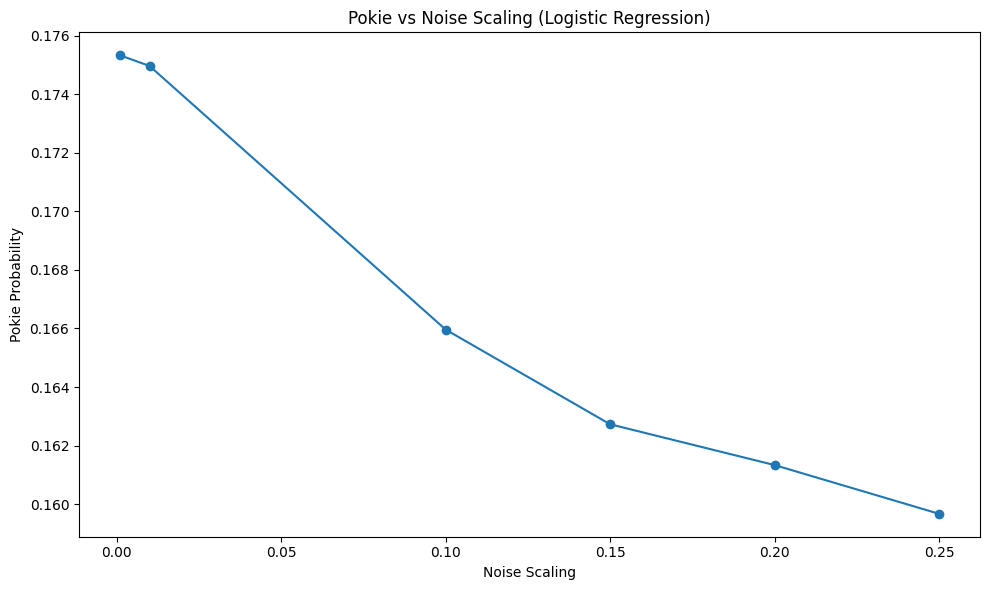

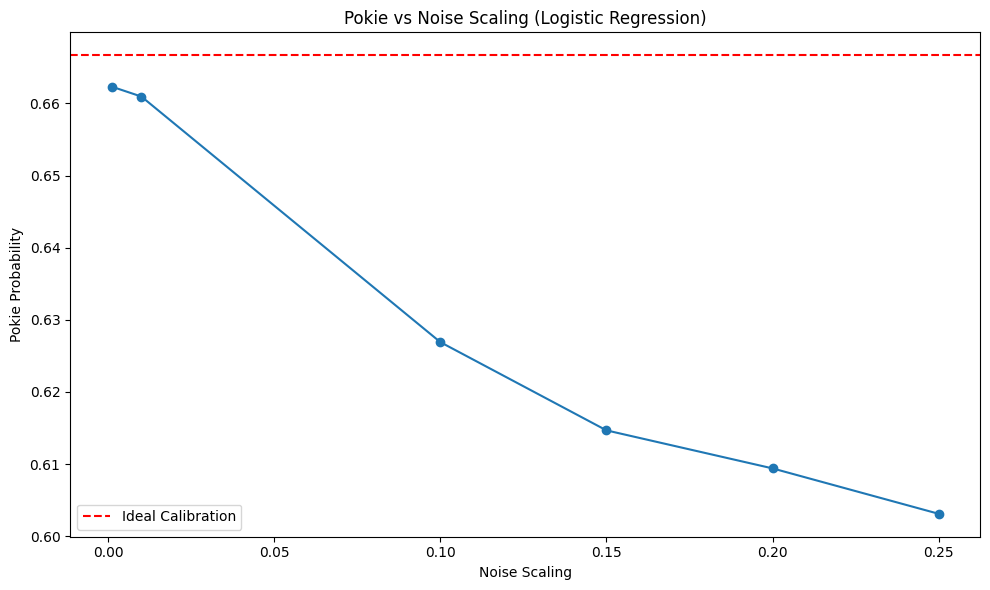

In [5]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, results, marker='o')
plt.xlabel('Noise Scaling')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Scaling (Logistic Regression)')
plt.tight_layout()
plt.savefig("../PLots/Logistic_Regression/Pokie_Logistic_Regression.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(noise_levels, calibrated, marker='o')
plt.xlabel('Noise Scaling')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Scaling (Logistic Regression)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/Logistic_Regression/Pokie_Logistic_Regression_Calibrated.pdf")
plt.show()

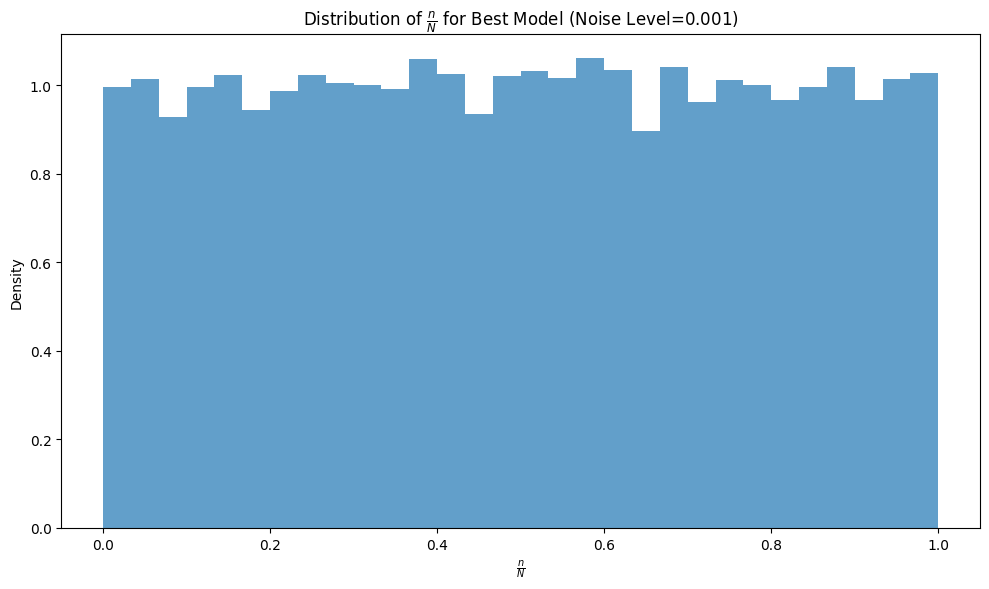

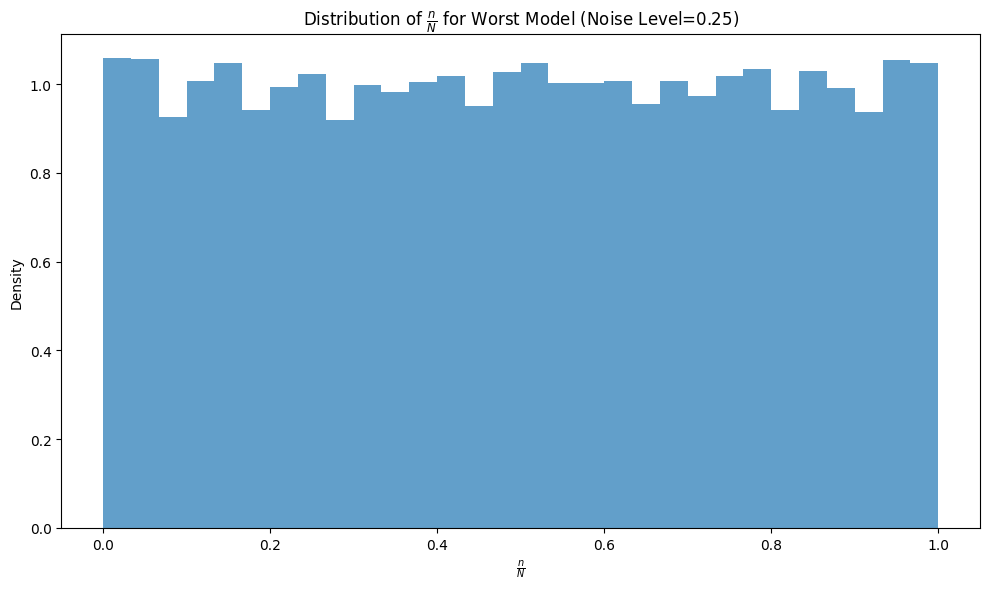

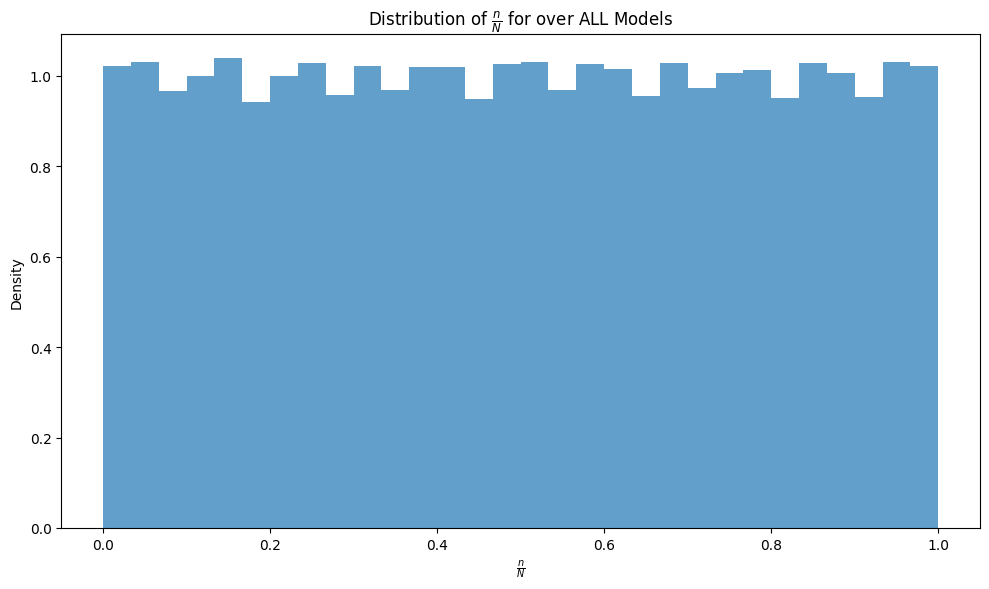

In [6]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (Noise Level={noise_levels[best_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Logistic_Regression/Pokie_Best_Model_n_over_N_Logistic_Regression.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (Noise Level={noise_levels[worst_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Logistic_Regression/Pokie_Worst_Model_n_over_N_Logistic_Regression.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Logistic_Regression/Pokie_n_over_N_Logistic_Regression.pdf")
plt.show()

In [7]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

out = pokie_with_convergence_estimate(gt_norm, posterior_norm, num_runs = 100)

l_values = np.linspace(0, len(results) - 1, len(results))
l_values = np.array(l_values)

emperical_pokie = out['empirical_pokie'].cpu().numpy()
theoretical_pokie = out['theoretical_pokie'].cpu().numpy()
convergence_gap = out['convergence_gap'].cpu().numpy()
E_lambda = out['E_lambda'].cpu().numpy()
E_lambda_sq = out['E_lambda_sq'].cpu().numpy()
n_over_N_vals = out['n_over_N_vals'].cpu().numpy()

print('\Modes:', l_values)
print('Emperical Pokie:', emperical_pokie)
print('Theoretical Pokie:', theoretical_pokie)
print('Convergence Gap:', convergence_gap)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 663.28it/s]

\Modes: [0. 1. 2. 3. 4. 5.]
Emperical Pokie: [0.17584825 0.174398   0.16654198 0.16281661 0.16100939 0.1593858 ]
Theoretical Pokie: [0.6662678  0.6659852  0.6668234  0.66722596 0.6666574  0.6669845 ]
Convergence Gap: [0.0022859  0.00747907 0.03798062 0.05244988 0.05870515 0.06516272]


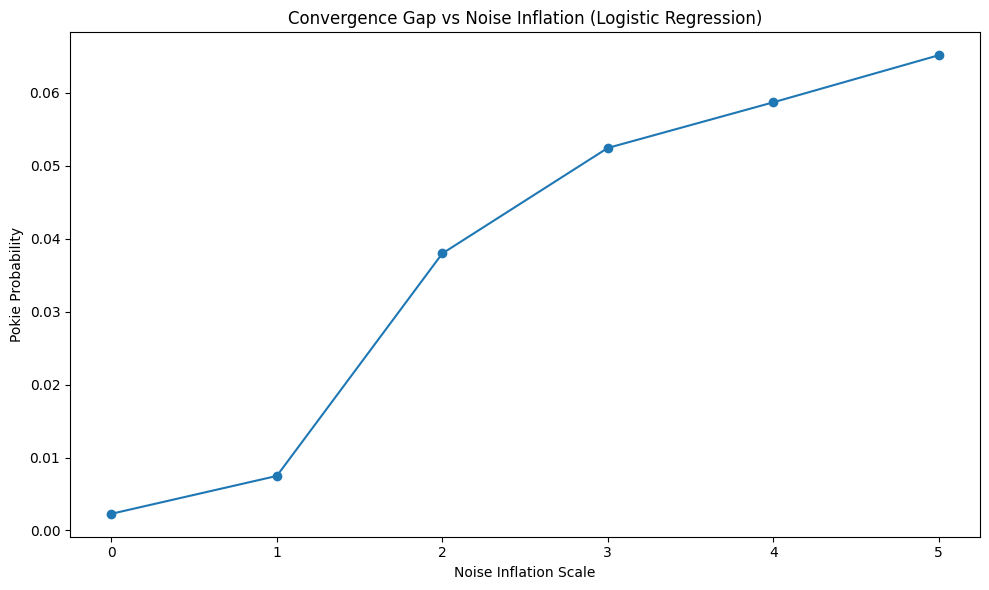

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(l_values, convergence_gap, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Convergence Gap vs Noise Inflation (Logistic Regression)')
plt.tight_layout()
plt.savefig("../PLots/Logistic_Regression/Pokie_Convergence_Gap_Logistic_Regression.pdf")
plt.show()

E[lambda]: 0.4988071918487549
E[lambda^2]: 0.33227428793907166


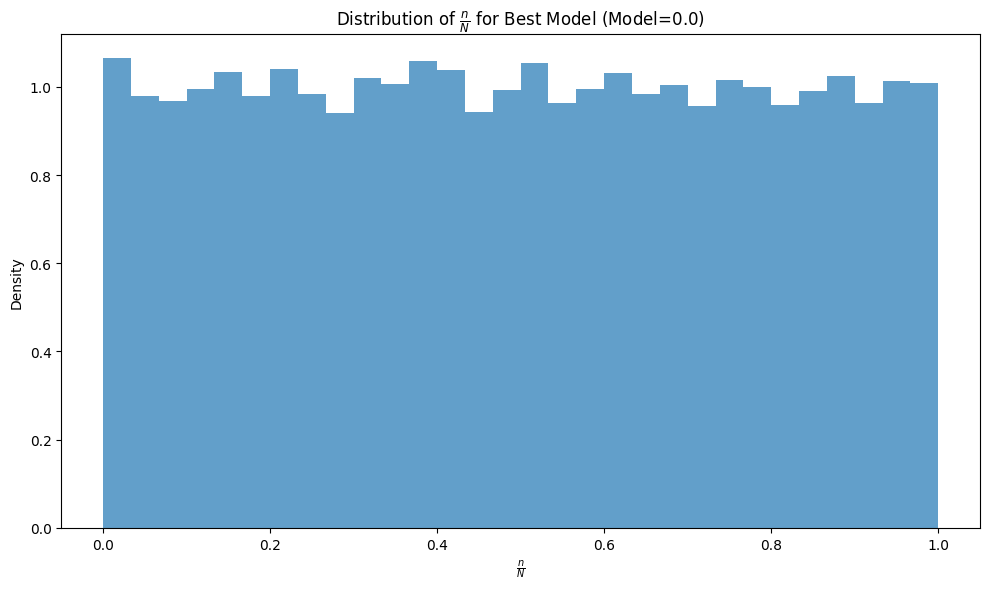

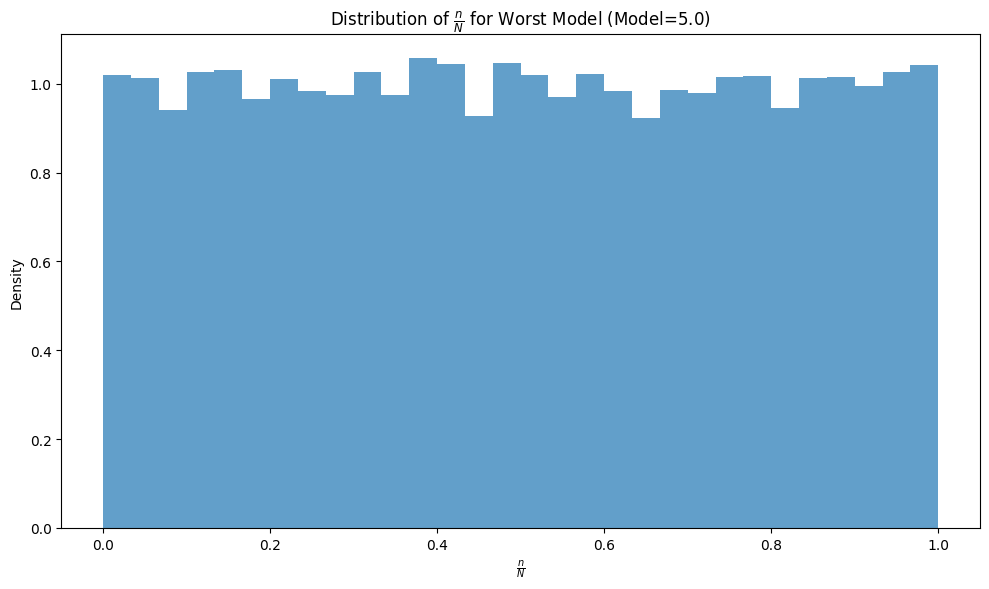

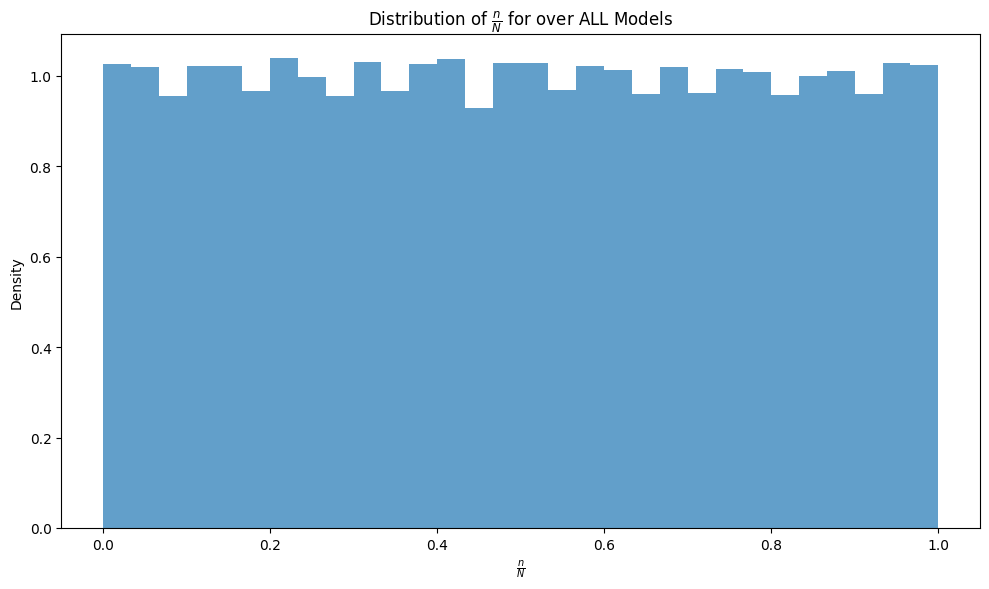

In [9]:
# Identify the best model
best_model_idx = np.argmin(convergence_gap)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

print("E[lambda]:", out["E_lambda"][best_model_idx].item())
print("E[lambda^2]:", out["E_lambda_sq"][best_model_idx].item())

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (Model={l_values[best_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Logistic_Regression/Pokie_Convergence_Best_Model_n_over_N_Logistic_Regression.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmax(convergence_gap)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (Model={l_values[worst_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Logistic_Regression/Pokie_Convergence_Worst_Model_n_over_N_Logistic_Regression.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Logistic_Regression/Pokie_Convergence_n_over_N_Logistic_Regression.pdf")
plt.show()